# IMPORT LIBRARIES

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import torch
from torch.utils.data.dataset import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

# CONNECT GOOGLE DRIVE (DATA DIRECTORY) TO GOOGLE COLAB

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
DATASET = 'EMOTION_DATASET'
BASE_DIR = os.path.join("/content/drive/Shareddrives/Lake Meeting/")
INPUT_DIR = os.path.join(BASE_DIR, 'INPUT', DATASET)

YOUR_NAME = "Test" # Put your name here so that it creates your directory of outputs
YOUR_DIR = os.path.join(BASE_DIR, "OUTPUT", YOUR_NAME, DATASET)
NUMPY_DIR = os.path.join(YOUR_DIR, 'NUMPY')
MODEL_DIR = os.path.join(YOUR_DIR, 'MODEL')
RESULT_DIR = os.path.join(YOUR_DIR, 'RESULT')

if not os.path.exists(NUMPY_DIR):
    os.makedirs(NUMPY_DIR)
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
if not os.path.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)

This notebook solves the time-series classification problem using Multi-layer Perceptron model. We solve the emotion classification problem where the input is a time series of length 259 and the classes are positive, neutral and negative emotion.

## HYPERPARAMETERS

In [6]:
batch_size = 50
time_steps = 259
channels = 1 
classes = 3
learning_rate = 0.005
epochs = 200

# LOADING DATA

In [7]:
print("#######################################################################")
print("LOAD DATA")
X = np.load(os.path.join(INPUT_DIR, "X_3_emotion_all_augmented_1.npy"), allow_pickle = True).astype(np.float32)
y = np.load(os.path.join(INPUT_DIR, "y_3_emotion_all_augmented_1.npy"), allow_pickle = True)
print(X.shape, y.shape)

print("#######################################################################")
print("TRAIN VAL TEST SPLIT")
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.2, random_state=42, stratify=train_y)
print(train_X.shape, train_y.shape, Counter(train_y))
print(val_X.shape, val_y.shape, Counter(val_y))
print(test_X.shape, test_y.shape, Counter(test_y))

print("#######################################################################")
print("PREPROCESS LABELS")
le = LabelEncoder()
le.fit(train_y)
print("CLASSES:{}".format(le.classes_))
train_y = le.transform(train_y)
val_y = le.transform(val_y)
test_y = le.transform(test_y)

print("#######################################################################")
print("PREPROCESS INPUTS")
mean = np.mean(train_X)
std = np.std(train_X)
train_X = (train_X - mean)/std
val_X = (val_X - mean)/std
test_X = (test_X - mean)/std

print("#######################################################################")
print("DATA LOADER")
class loader(Dataset):

    def __init__(self, X, y):
        self.data = X
        self.labels = y

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

train_data = loader(X=train_X, y=train_y)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=0)
val_data = loader(X=val_X, y=val_y)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True, num_workers=0)
test_data = loader(X=test_X, y=test_y)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True, num_workers=0)
print("Train batch:{}\tVal batch:{}\tTest batch:{}".format(len(train_loader), len(val_loader), len(test_loader)))

#######################################################################
LOAD DATA
(5760, 259) (5760,)
#######################################################################
TRAIN VAL TEST SPLIT
(3686, 259) (3686,) Counter({'negative': 2457, 'neutral': 738, 'positive': 491})
(922, 259) (922,) Counter({'negative': 615, 'neutral': 184, 'positive': 123})
(1152, 259) (1152,) Counter({'negative': 768, 'neutral': 230, 'positive': 154})
#######################################################################
PREPROCESS LABELS
CLASSES:['negative' 'neutral' 'positive']
#######################################################################
PREPROCESS INPUTS
#######################################################################
DATA LOADER
Train batch:74	Val batch:19	Test batch:24


# DEFINE MODEL

In [8]:
print("#######################################################################")
print("DEFINE MODEL")
class ANN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ANN,self).__init__()
        self.fc_1 = torch.nn.Linear(in_channels, 32)
        self.fc_2 = torch.nn.Linear(32, out_channels)

        self.relu = torch.nn.ReLU()

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)

    def forward(self,x):
        x_fc_1 = self.relu(self.fc_1(x))
        out = self.fc_2(x_fc_1)
        return out

print("#######################################################################")
print("BUILD MODEL")
model = ANN(in_channels=time_steps, out_channels=classes)
model = model.to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

print(model)

#######################################################################
DEFINE MODEL
#######################################################################
BUILD MODEL
ANN(
  (fc_1): Linear(in_features=259, out_features=32, bias=True)
  (fc_2): Linear(in_features=32, out_features=3, bias=True)
  (relu): ReLU()
)


# TRAINING MODEL

#######################################################################
TRAIN MODEL
Epoch:1	Train Loss:0.8596377759366423	Val Loss:0.8057437915551035	Train Score:0.4027	Val Score:0.3640	Max Score:0.0000
Epoch:2	Train Loss:0.7730934418536521	Val Loss:0.7693616120438826	Train Score:0.4205	Val Score:0.3760	Max Score:0.3640
Epoch:3	Train Loss:0.7535801102986207	Val Loss:0.7722548120900204	Train Score:0.4187	Val Score:0.3667	Max Score:0.3760
Epoch:4	Train Loss:0.7385395507554751	Val Loss:0.7704226531480488	Train Score:0.4527	Val Score:0.4095	Max Score:0.3760
Epoch:5	Train Loss:0.7235937625975222	Val Loss:0.7428111747691506	Train Score:0.4711	Val Score:0.4029	Max Score:0.4095
Epoch:6	Train Loss:0.7089672813544402	Val Loss:0.7548330771295648	Train Score:0.4472	Val Score:0.4044	Max Score:0.4095
Epoch:7	Train Loss:0.6908591655460564	Val Loss:0.7381765685583416	Train Score:0.5065	Val Score:0.4490	Max Score:0.4095
Epoch:8	Train Loss:0.6838811156717507	Val Loss:0.7276068690576052	Train Score:0.513

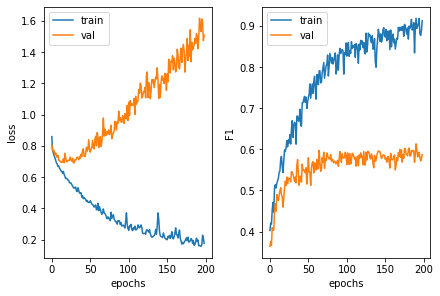

In [9]:
print("#######################################################################")
print("TRAIN MODEL")
train_loss = []
val_loss = []
train_score = []
val_score = []
max_score = 0
for epoch in range(1,epochs):

    model.train()

    total_loss = 0
    for batch, [data, labels] in enumerate(train_loader):
        optimizer.zero_grad()
        out = model(data.to('cuda'))
        loss = criterion(out, labels.to('cuda'))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print('Epoch:{}\tTrain Loss:{}'.format(epoch, total_loss/(batch+1)), end="\t")
    train_loss.append(total_loss/(batch+1))

    total_loss = 0
    for batch, [data, labels] in enumerate(val_loader):
        out = model(data.to('cuda'))
        loss = criterion(out, labels.to('cuda'))
        total_loss += loss.item()
    print('Val Loss:{}'.format(total_loss/(batch+1)), end="\t")
    val_loss.append(total_loss/(batch+1))

    model.eval()

    pred_labels = np.zeros(len(train_loader)*batch_size).astype(np.int)
    true_labels = np.zeros(len(train_loader)*batch_size).astype(np.int)
    total = 0
    for batch, [data, labels] in enumerate(train_loader):
        out = model(data.to('cuda'))
        out = torch.argmax(torch.nn.functional.softmax(out, dim=1), dim=1)
        pred_labels[total:total+len(labels)] = out.detach().cpu().numpy()
        true_labels[total:total+len(labels)] = labels.cpu().numpy()
        total += len(labels)
    pred_labels = pred_labels[:total]
    true_labels = true_labels[:total]
    train_score.append(f1_score(y_true=true_labels, y_pred=pred_labels, average='macro'))
    print('Train Score:{:.4f}'.format(train_score[-1]), end="\t")

    pred_labels = np.zeros(len(val_loader)*batch_size).astype(np.int)
    true_labels = np.zeros(len(val_loader)*batch_size).astype(np.int)
    total = 0
    for batch, [data, labels] in enumerate(val_loader):
        out = model(data.to('cuda'))
        out = torch.argmax(torch.nn.functional.softmax(out, dim=1), dim=1)
        pred_labels[total:total+len(labels)] = out.detach().cpu().numpy()
        true_labels[total:total+len(labels)] = labels.cpu().numpy()
        total += len(labels)
    pred_labels = pred_labels[:total]
    true_labels = true_labels[:total]
    val_score.append(f1_score(y_true=true_labels, y_pred=pred_labels, average='macro'))
    print("Val Score:{:.4f}\tMax Score:{:.4f}".format(val_score[-1], max_score))
    if max_score<val_score[-1]:
        max_score = val_score[-1]
        torch.save(model.state_dict(), os.path.join(MODEL_DIR, "ANN.pt"))

fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
ax = axs[0]
ax.plot(train_loss, label='train')
ax.plot(val_loss, label='val')
ax.legend()
ax.set_ylabel('loss')
ax.set_xlabel('epochs')
ax = axs[1] 
ax.plot(train_score, label='train')
ax.plot(val_score, label='val')
ax.legend()
ax.set_ylabel('F1')
ax.set_xlabel('epochs')
plt.savefig(os.path.join(RESULT_DIR, "ANN.pdf"), format = "pdf")
plt.show()

# TEST MODEL

In [10]:
print("#######################################################################")
print("LOAD MODEL")
model.load_state_dict(torch.load(os.path.join(MODEL_DIR, "ANN.pt")))
model.eval()

#######################################################################
LOAD MODEL


ANN(
  (fc_1): Linear(in_features=259, out_features=32, bias=True)
  (fc_2): Linear(in_features=32, out_features=3, bias=True)
  (relu): ReLU()
)

#######################################################################
TEST ON TRAIN SET
Scores:
              precision    recall  f1-score   support

    negative      0.951     0.977     0.964      2457
     neutral      0.953     0.873     0.911       738
    positive      0.887     0.878     0.882       491

    accuracy                          0.943      3686
   macro avg      0.930     0.909     0.919      3686
weighted avg      0.943     0.943     0.943      3686


Confusion_matrix:


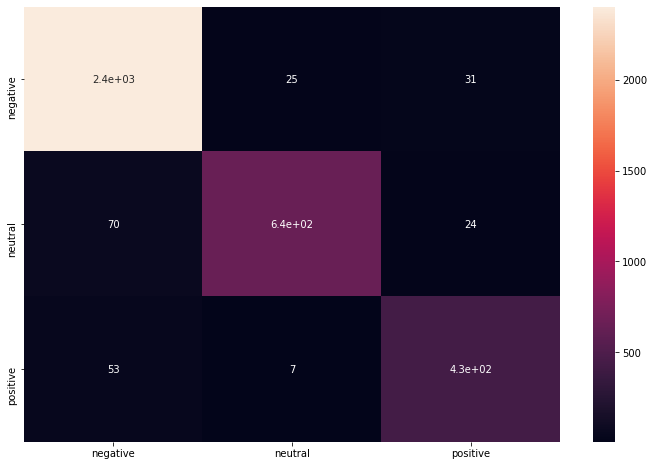

In [11]:
print("#######################################################################")
print("TEST ON TRAIN SET")
pred_labels = np.zeros(len(train_loader)*batch_size).astype(np.int)
true_labels = np.zeros(len(train_loader)*batch_size).astype(np.int)
total = 0
for batch, [data, labels] in enumerate(train_loader):
    out = model(data.to('cuda'))
    out = torch.argmax(torch.nn.functional.softmax(out, dim=1), dim=1)
    pred_labels[total:total+len(labels)] = out.detach().cpu().numpy()
    true_labels[total:total+len(labels)] = labels.cpu().numpy()
    total += len(labels)
pred_labels = pred_labels[:total]
true_labels = true_labels[:total]
print("Scores:")
print(classification_report(true_labels, pred_labels, target_names=le.classes_, digits=3))
print("\nConfusion_matrix:")
cm = confusion_matrix(true_labels, pred_labels)
cm_df = pd.DataFrame(cm, le.classes_, le.classes_)                      
plt.figure(figsize=(12,8))  
sns.heatmap(cm_df, annot=True)

#######################################################################
TEST ON VAL SET
Scores:
              precision    recall  f1-score   support

    negative      0.831     0.831     0.831       615
     neutral      0.621     0.587     0.603       184
    positive      0.391     0.423     0.406       123

    accuracy                          0.728       922
   macro avg      0.614     0.614     0.613       922
weighted avg      0.730     0.728     0.729       922


Confusion_matrix:


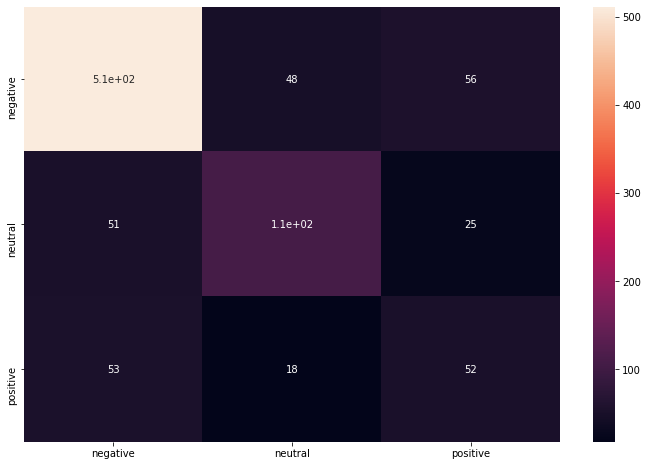

In [12]:
print("#######################################################################")
print("TEST ON VAL SET")
pred_labels = np.zeros(len(val_loader)*batch_size).astype(np.int)
true_labels = np.zeros(len(val_loader)*batch_size).astype(np.int)
total = 0
for batch, [data, labels] in enumerate(val_loader):
    out = model(data.to('cuda'))
    out = torch.argmax(torch.nn.functional.softmax(out, dim=1), dim=1)
    pred_labels[total:total+len(labels)] = out.detach().cpu().numpy()
    true_labels[total:total+len(labels)] = labels.cpu().numpy()
    total += len(labels)
pred_labels = pred_labels[:total]
true_labels = true_labels[:total]
print("Scores:")
print(classification_report(true_labels, pred_labels, target_names=le.classes_, digits=3))
print("\nConfusion_matrix:")
cm = confusion_matrix(true_labels, pred_labels)
cm_df = pd.DataFrame(cm, le.classes_, le.classes_)                      
plt.figure(figsize=(12,8))  
sns.heatmap(cm_df, annot=True)

#######################################################################
TEST ON TEST SET
Scores:
              precision    recall  f1-score   support

    negative      0.814     0.831     0.822       768
     neutral      0.617     0.561     0.588       230
    positive      0.453     0.468     0.460       154

    accuracy                          0.728      1152
   macro avg      0.628     0.620     0.623      1152
weighted avg      0.726     0.728     0.727      1152


Confusion_matrix:


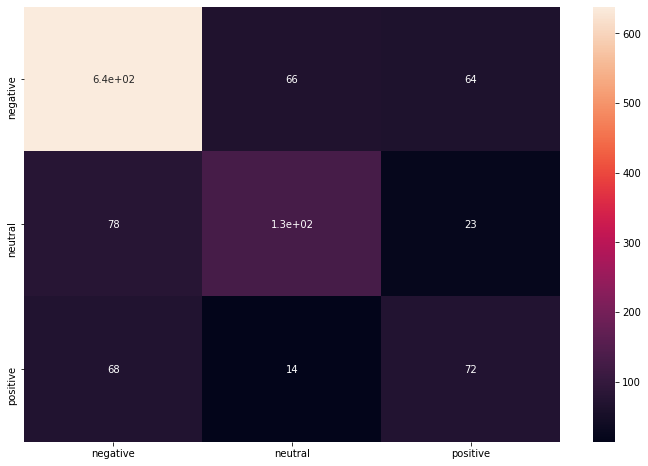

In [13]:
print("#######################################################################")
print("TEST ON TEST SET")
pred_labels = np.zeros(len(test_loader)*batch_size).astype(np.int)
true_labels = np.zeros(len(test_loader)*batch_size).astype(np.int)
total = 0
for batch, [data, labels] in enumerate(test_loader):
    out = model(data.to('cuda'))
    out = torch.argmax(torch.nn.functional.softmax(out, dim=1), dim=1)
    pred_labels[total:total+len(labels)] = out.detach().cpu().numpy()
    true_labels[total:total+len(labels)] = labels.cpu().numpy()
    total += len(labels)
pred_labels = pred_labels[:total]
true_labels = true_labels[:total]
print("Scores:")
print(classification_report(true_labels, pred_labels, target_names=le.classes_, digits=3))
print("\nConfusion_matrix:")
cm = confusion_matrix(true_labels, pred_labels)
cm_df = pd.DataFrame(cm, le.classes_, le.classes_)                      
plt.figure(figsize=(12,8))  
sns.heatmap(cm_df, annot=True)